# Benchmarking

In this notebook we will test some naive methods, and use these as benchmark for the more advanced machine learning algorithms we will use to predict stock prices.

In [1]:
import matplotlib

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from data.get_50_highest_weights import get_sp_50_highest_weights_symbols
from data_preparation.ochlva_data import OCHLVAData
from estimators import latest_day

In [2]:
matplotlib.use('nbAgg')

In [3]:
import matplotlib.pyplot as plt

In [4]:
# Load the SP500 data
ochlv_data = OCHLVAData()

In [5]:
# Load three other stocks
symbols = get_sp_50_highest_weights_symbols()

# Select symbols with high, medium and low weights
selected_symbols = (symbols.iloc[0], symbols.iloc[len(symbols)//2], symbols.iloc[-1])

for s in selected_symbols:
    ochlv_data.load_data(s)

<IPython.core.display.Javascript object>


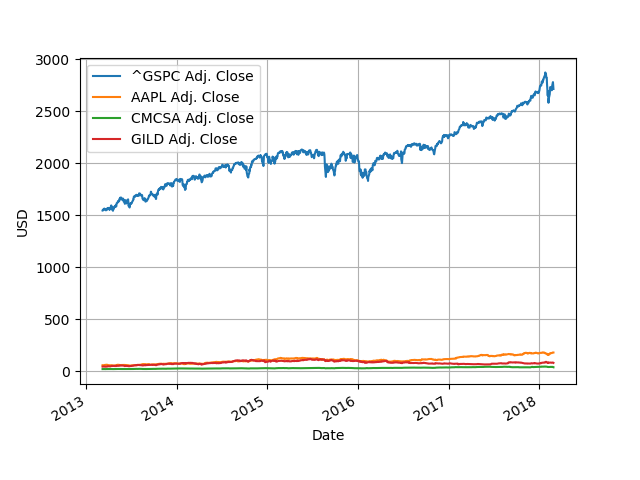

In [6]:
ax = ochlv_data.plot(['Adj. Close'])
plt.show()

The other stocks are order of magnitude lower than SP500, so treat seperately

In [7]:
sp500_adj_close = ochlv_data.clean_data['^GSPC'].loc[:, ['Adj. Close']]

In [8]:
train, test = train_test_split(sp500_adj_close, shuffle=False, test_size=.2)

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (1008, 1)
Test shape: (252, 1)


<IPython.core.display.Javascript object>


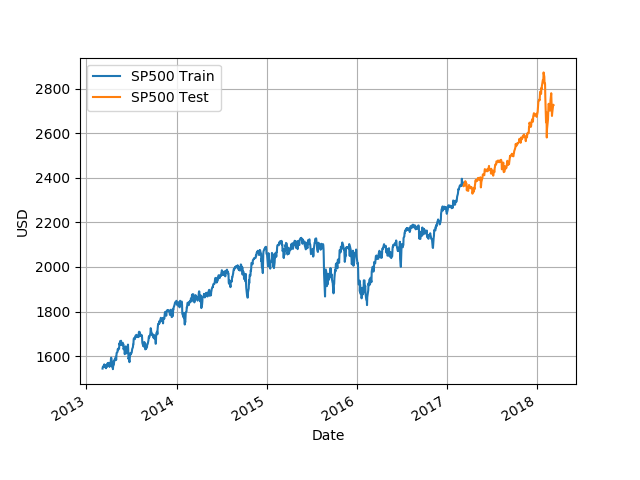

In [9]:
ax = train.plot()
_ = test.plot(ax=ax)
ax.legend(['SP500 Train', 'SP500 Test'])

ax.grid()
_ = ax.set_ylabel('USD')

plt.show()

In [10]:
def get_rolling_prediction(reg, train, test, days):
    """
    Returns a rolling prediction.
    
    Parameters
    ----------
    reg : object
        The model to fit and make prediction from
    train : array, shape (n_test_samples, n_features)
        The training set
    test : array, shape (n_test_samples, n_features)
        The test set
    days : int
        The number of days to do the prediction from
    
    Returns
    -------
    y_pred : list
        A list of the consecutive predictions
    """
    
    # Initialize the predictions
    y_pred = []
    
    # Loop over the test set
    # For each step, we will add one training day to the training set, retrain the model and make a prediction d days ahead 
    # The first prediction is making a prediction on the test set, so we add 1 to days to account for this
    for i in range(test.shape[0] - d+1):
        rolling_train = pd.concat([train, test.iloc[:i]])
        reg.fit(rolling_train.values)
        y_pred.append(reg.predict(rolling_train.values)[-1])
        
    return y_pred

In [11]:
# Initialize a dict on the form {prediction_days: DataFrame}
predictions = {7:{'df': None, 'rmse': None, 'nrmse':None},
               14:{'df': None,'rmse': None, 'nrmse':None}, 
               28:{'df': None,'rmse': None, 'nrmse':None}}

for d in predictions.keys():
    # Initialize the regressor
    reg = latest_day.LatestDay(days=d)

    y_pred = get_rolling_prediction(reg, train, test, d)

    # Cast into dataframe for easier handling
    # As the first prediction is on the training set, we subtract 1 in the indexing to account for this
    predictions[d]['df'] = pd.DataFrame(y_pred, index=test.index[d-1:], columns=['Adj. Close'])
    predictions[d]['rmse'] = np.sqrt(mean_squared_error(test.iloc[d-1:], y_pred))
    predictions[d]['nrmse'] = predictions[d]['rmse']/(test.values.max() - test.values.min())

Normalized root mean squared error for 7 days prediction: 0.08
Normalized root mean squared error for 14 days prediction: 0.11
Normalized root mean squared error for 28 days prediction: 0.13


<IPython.core.display.Javascript object>


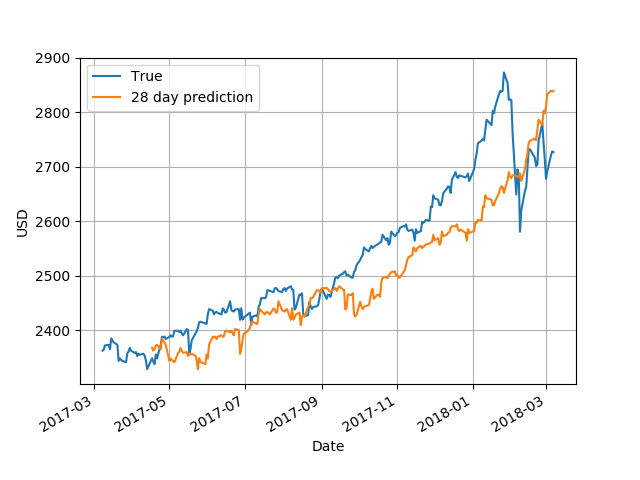

In [12]:
ax = test.plot()

legends = []
for d in predictions.keys():
    print(f'Normalized root mean squared error for {d} days prediction: {predictions[d]["nrmse"]:.2f}')
        
d = 28
_ = predictions[d]['df'].plot(ax=ax)
legends.append(f'{d} day prediction')      
    
ax.legend(['True', *legends])
ax.grid()
_ = ax.set_ylabel('USD')
plt.show()